In [120]:
from numpy import matrix, array, zeros, empty, sqrt, ones, dot, append, mean, cov, transpose, linspace
from numpy.linalg import inv, pinv
import numpy as np
import scipy.optimize
import math

# This algorithm performs a Black-Litterman portfolio construction. The framework
# is built on the classical mean-variance approach, but allows the investor to 
# specify views about the over- or under- performance of various assets.
# Uses ideas from the Global Minimum Variance Portfolio 
# algorithm posted on Quantopian. Ideas also adopted from 
# http://www.quantandfinancial.com/2013/08/portfolio-optimization-ii-black.html.

# Compute the expected return of the portfolio.
def compute_mean(W,R):
    return sum(R*W)

# Compute the variance of the portfolio.
def compute_var(W,C):
    return dot(dot(W, C), W)

# Combination of the two functions above - mean and variance of returns calculation. 
def compute_mean_var(W, R, C):
    return compute_mean(W, R), compute_var(W, C)

# objective function you can add other constrains or targets here
def fitness(W, R, C, r, daily_return, asset_beta):
    # For given level of return r, find weights which minimizes portfolio variance.
    mean_1, var = compute_mean_var(W, R, C)
    # Penalty for not meeting stated portfolio return effectively serves as optimization constraint
    # Here, r is the 'target' return
    cum_p = compute_historical_performance(daily_return, W)
    drawdown = max_drawdown(cum_p)
    
    penalty = 100*abs(mean_1-r)
    penalty1 = 1*np.maximum(drawdown-0.10,0)
    penalty2 = 1*np.maximum(W@asset_beta-1.5,0)
    return var + penalty + penalty1+penalty2

# Solve for optimal portfolio weights
def solve_weights(R, C, rf, r_target, daily_return, asset_beta):
    n = len(R)
    W = ones([n])/n # Start optimization with equal weights
    b_ = [(0.00,0.4) for i in range(n)] # Bounds for decision variables
    c_ = ({'type':'eq', 'fun': lambda W: sum(W)-1. }) # Constraints - weights must sum to 1
    # 'target' return is the expected return on the market portfolio
    optimized = scipy.optimize.minimize(fitness, W, (R, C, r_target, daily_return, asset_beta), method='SLSQP', constraints=c_, bounds=b_)
    if not optimized.success:
        raise BaseException(optimized.message)
    return optimized.x     
        
# Weights - array of asset weights (derived from market capitalizations)
# Expreturns - expected returns based on historical data
# Covars - covariance matrix of asset returns based on historical data
def assets_meanvar(daily_returns):    
    
    # Calculate expected returns
    expreturns = array([])
    (rows, cols) = daily_returns.shape
    for r in range(rows):
        expreturns = append(expreturns, mean(daily_returns[r]))
    
    # Compute covariance matrix
    covars = cov(daily_returns)
    # Annualize expected returns and covariances
    # Assumes 255 trading days per year    
    expreturns = (1+expreturns)**255-1
    covars = covars * 255
    
    return expreturns, covars

def compute_historical_performance(daily_returns ,W):
    ret_p = np.log(1+W@daily_returns)
    cum_p = np.exp(np.cumsum(ret_p))
    return cum_p

def max_drawdown(X):
    mdd = 0
    peak = X[0]
    for x in X:
        if x > peak: 
            peak = x
        dd = (peak - x) / peak
        if dd > mdd:
            mdd = dd
    return mdd

In [121]:
import numpy as np
import pandas as pd
from googlefinance.client import get_price_data, get_prices_data, get_prices_time_data
params = [
    {
    'q': "VFV", 
    'x': "TSE", 
    },
    {
    'q': "IEUR", 
    'x': "NYSEARCA", 
    },
    {
    'q': "JPNH", 
    'x': "EPA", 
    },
    {
    'q': "ASHR", 
    'x': "NYSEARCA", 
    },
    {
    'q': "LYAEJ-USD", 
    'x': "SWX", 
    },
    {
    'q': "EEM", 
    'x': "NYSEARCA", 
    },
    {
    'q': "SSFCX", 
    'x': "MUTF", 
    },
    {
    'q': "JNK", 
    'x': "NYSEARCA", 
    },
    {
    'q': "ZROZ", 
    'x': "NYSEARCA", 
    },
    {
    'q': "EMB", 
    'x': "BMV", 
    }
    ]
period = '10Y'
# get price data (return pandas dataframe)
df = get_prices_data(params, period)
print(df)

            VFV_Open  VFV_High  VFV_Low  VFV_Close  VFV_Volume  IEUR_Open  \
2008-02-12       NaN       NaN      NaN        NaN         NaN        NaN   
2008-02-13       NaN       NaN      NaN        NaN         NaN        NaN   
2008-02-14       NaN       NaN      NaN        NaN         NaN        NaN   
2008-02-15       NaN       NaN      NaN        NaN         NaN        NaN   
2008-02-16       NaN       NaN      NaN        NaN         NaN        NaN   
2008-02-20       NaN       NaN      NaN        NaN         NaN        NaN   
2008-02-21       NaN       NaN      NaN        NaN         NaN        NaN   
2008-02-22       NaN       NaN      NaN        NaN         NaN        NaN   
2008-02-23       NaN       NaN      NaN        NaN         NaN        NaN   
2008-02-26       NaN       NaN      NaN        NaN         NaN        NaN   
2008-02-27       NaN       NaN      NaN        NaN         NaN        NaN   
2008-02-28       NaN       NaN      NaN        NaN         NaN        NaN   

In [122]:
asset_list = ['VFV_Close','IEUR_Close','JPNH_Close','ASHR_Close','LYAEJ-USD_Close', 'EEM_Close', 'SSFCX_Close', 'JNK_Close','ZROZ_Close','EMB_Close']
daily_price = df.fillna(method='ffill')[asset_list]

In [123]:
daily_return = daily_price.pct_change().dropna()
print(daily_return)
etf_return = daily_return
etf_date = pd.to_datetime(daily_return.index)

            VFV_Close  IEUR_Close  JPNH_Close  ASHR_Close  LYAEJ-USD_Close  \
2014-09-25   0.006162    0.002244   -0.005331    0.029153        -0.009570   
2014-09-26  -0.009952   -0.014184    0.013445   -0.011641         0.000000   
2014-09-27   0.012113    0.003572    0.000000    0.005497         0.000000   
2014-09-29   0.000000    0.000000   -0.005916    0.000000        -0.018537   
2014-09-30  -0.003565   -0.006898   -0.001803   -0.010152         0.001005   
2014-10-01   0.003833   -0.002388   -0.016170    0.016568         0.000000   
2014-10-02  -0.016802   -0.011314   -0.037738   -0.008925        -0.009835   
2014-10-03  -0.001813   -0.012984    0.030344   -0.003524         0.011149   
2014-10-04   0.021012   -0.001672    0.000000    0.009430         0.000000   
2014-10-06   0.000000    0.000000   -0.006112    0.000000         0.000401   
2014-10-07  -0.014228    0.008264   -0.010622    0.010899        -0.002204   
2014-10-08  -0.011340   -0.020490   -0.007252   -0.009241       

In [124]:
import numpy as np
import pandas as pd
df = pd.read_excel('xlsx/benchmark.xlsx', sheetname = 'Daily_Index_Price')
# use data from 2000.1.1 onward
df_sub = df.iloc[2:]
df_new = pd.DataFrame(index = pd.to_datetime(df_sub.index))
for i in range(df_sub.shape[1]):
    df_new['asset'+str(i+1)]= pd.to_numeric(df_sub.iloc[:,i].values)
    # partially clear data, ideally trading days, but here weekdays
df_weekday = df_new[(df_new.index.weekday<5)]
# use data from 2015-10-1 onwards
return_index = df_weekday[df_weekday.index>'2009-12-31']
return_index = return_index.values
# compute daily return
daily_return = (return_index[1:,:]-return_index[:-1,:])/return_index[:-1,:]
index_return = pd.DataFrame(index = df_weekday[df_weekday.index>'2009-12-31'].index[1:], data = daily_return)
print(index_return)
index_date = index_return.index

                   0         1         2         3         4         5  \
2010-01-04  0.016043  0.014613  0.008991 -0.010185  0.026207  0.015200   
2010-01-05  0.003116 -0.000335  0.004171  0.011844  0.011195  0.010702   
2010-01-06  0.000546  0.001005  0.012571 -0.008520 -0.000865  0.006392   
2010-01-07  0.004001  0.000000  0.000773 -0.018880 -0.004848 -0.007174   
2010-01-08  0.002882  0.004128  0.010130  0.001009  0.004001  0.001962   
2010-01-11  0.001747 -0.001111  0.000000  0.005242  0.004679  0.011472   
2010-01-12 -0.009381 -0.009344  0.013641  0.019054 -0.009659 -0.006702   
2010-01-13  0.008326  0.002021 -0.010596 -0.030944 -0.003135 -0.008901   
2010-01-14  0.002427  0.007284  0.015879  0.013519  0.000874  0.001186   
2010-01-15 -0.010823 -0.009456  0.007706  0.002675 -0.007506 -0.002487   
2010-01-18  0.000000  0.006963 -0.009158  0.004015  0.000000  0.001761   
2010-01-19  0.012500  0.008142 -0.008135  0.003020  0.018994  0.000849   
2010-01-20 -0.010598 -0.015488 -0.0053

In [125]:
daily_return = index_return.values.transpose()
expreturns, covars = assets_meanvar(daily_return)
R = expreturns # R is the vector of expected returns
C = covars # C is the covariance matrix
print(R)
print(np.diag(C))

[ 0.12769818  0.06316622  0.11191514  0.03006102  0.06172941  0.03928718
  0.02506286  0.0784468   0.03480887  0.03606582]
[ 0.02108975  0.02724581  0.03808849  0.04560234  0.03642326  0.02426953
  0.00235012  0.00142116  0.00070556  0.00850501]


In [126]:
from scipy.stats import linregress
asset_beta = np.zeros(daily_return.shape[0])
for i in range(daily_return.shape[0]): 
    asset_beta[i], alpha, r, _, _ =  linregress(daily_return[0,:],daily_return[i,:])
print(asset_beta)

[ 1.          0.73572219  0.1954398   0.1910102   1.06693384  0.51725045
 -0.02063652  0.10532324 -0.06059827  0.24800907]


In [127]:
rf = 0.01
R_historical = R
# use historical data as prior mean and cov
Pi = R - rf
print('historical average return')
print(Pi+rf)

benchmark_weight = np.array([0.15,0.05,0.05,0.05,0.15,0.1,0.15,0.1,0.15,0.05])

new_mean = compute_mean(benchmark_weight,R)
new_var = compute_var(benchmark_weight,C)


lmb = (new_mean - rf) / new_var # Compute implied equity risk premium
Pi = dot(dot(lmb, C), benchmark_weight) # Compute equilibrium excess returns
print('capm implied return')
print(Pi+rf)

target_return = 0.06

# Solve for weights before incorporating views (example target = 0.05)
W = solve_weights(Pi+rf, C, rf, r_target = target_return, daily_return = daily_return, asset_beta = asset_beta)
mean_prior, var_prior = compute_mean_var(W, Pi+rf, C) 

cum_p = compute_historical_performance(daily_return, W)
drawdown = max_drawdown(cum_p)

print('the prior new weights is')
print(W)
print('the prior portfolio expected return is')
print(mean_prior)
print('the prior portfolio expected volatility is')
print(np.sqrt(var_prior))
print('the historical max_drawdown is')
print(drawdown)
print('the portfolio beta is')
print(W@asset_beta)

historical average return
[ 0.12769818  0.06316622  0.11191514  0.03006102  0.06172941  0.03928718
  0.02506286  0.0784468   0.03480887  0.03606582]
capm implied return
[ 0.08749958  0.09052405  0.06156542  0.07027835  0.12598947  0.09796658
  0.01492049  0.02496292  0.00658626  0.05135991]
the prior new weights is
[ 0.4         0.04147536  0.02113002  0.          0.13739462  0.          0.
  0.          0.4         0.        ]
the prior portfolio expected return is
0.0600000078767
the prior portfolio expected volatility is
0.0834535156759
the historical max_drawdown is
0.114176750593
the portfolio beta is
0.556995651947


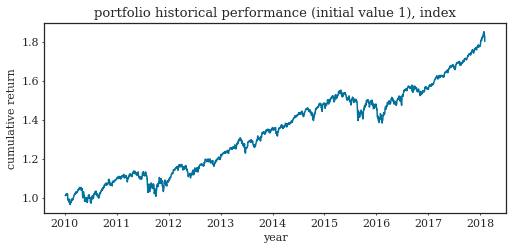

In [128]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white', {"xtick.major.size": 2, "ytick.major.size": 2})
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71","#f4cae4"]
sns.set_palette(sns.color_palette(flatui,7))

font = {'family' : 'Serif',
         'weight': 'normal',
         'size'  : 11}
mpl.rc('font', **font)
# a4 size: 8.27,11.69
fig = plt.figure(figsize=(8.27,3.5))
ax = fig.add_subplot(111)

ax.plot(index_date, cum_p, c = 'xkcd:ocean blue')
ax.set_xlabel('year')
ax.set_ylabel('cumulative return')
ax.set_title('portfolio historical performance (initial value 1), index')

plt.legend(loc='best') 
plt.show()     

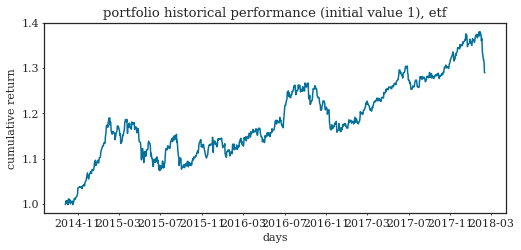

In [129]:
cum_p = compute_historical_performance(etf_return.values.transpose(), W)
drawdown = max_drawdown(cum_p)
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white', {"xtick.major.size": 2, "ytick.major.size": 2})
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71","#f4cae4"]
sns.set_palette(sns.color_palette(flatui,7))

font = {'family' : 'Serif',
         'weight': 'normal',
         'size'  : 11}
mpl.rc('font', **font)
# a4 size: 8.27,11.69
fig = plt.figure(figsize=(8.27,3.5))
ax = fig.add_subplot(111)

ax.plot(etf_date, cum_p, c = 'xkcd:ocean blue')
ax.set_xlabel('days')
ax.set_ylabel('cumulative return')
ax.set_title('portfolio historical performance (initial value 1), etf')

plt.legend(loc='best') 
plt.show()     

In [130]:
# plot the prior m-v frontier
n = 80
plot_mean = np.zeros(n)
plot_var = np.zeros(n)
for i in range(n):
    r_target = 0.02+i*0.001
    W = solve_weights(Pi+rf, C, rf, r_target = r_target, daily_return = daily_return, asset_beta = asset_beta)
    plot_mean[i], plot_var[i] = compute_mean_var(W, Pi+rf, C) 

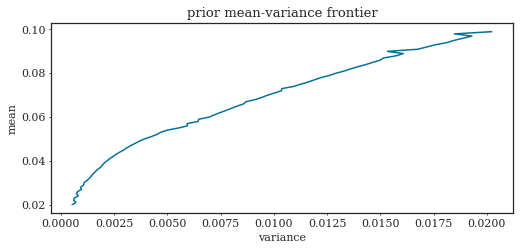

In [131]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white', {"xtick.major.size": 2, "ytick.major.size": 2})
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71","#f4cae4"]
sns.set_palette(sns.color_palette(flatui,7))

font = {'family' : 'Serif',
         'weight': 'normal',
         'size'  : 11}
mpl.rc('font', **font)
# a4 size: 8.27,11.69
fig = plt.figure(figsize=(8.27,3.5))
ax = fig.add_subplot(111)

ax.plot(plot_var, plot_mean, c = 'xkcd:ocean blue')
ax.set_xlabel('variance')
ax.set_ylabel('mean')
ax.set_title('prior mean-variance frontier')

plt.legend(loc='best') 
plt.show()            

In [152]:
# VIEWS ON ASSET PERFORMANCE
# asset 1 will out perform asset 2 by 3%, and
# that asset 1 will outperform asset 3 by 2%.
# that asset 5 will under outperform the benchmark by 5%
P = np.array([[0,0,1,0,0,0,0,0,0,0],
              [0,0,0,1,0,0,0,0,0,0],
              [0,0,0,0,1,0,0,0,0,0],
              [0,0,0,0,0,1,0,0,0,0],
              [1,0,0,0,0,0,0,0,0,0],
              [0,1,0,0,0,0,0,0,0,0]])
Q = np.array([0.086,0.0622,0.055,0.1218,0.089,0.1157])

## note adjust tau to adjust your confidence about your view
tau = 0.025 # tau is a scalar indicating the uncertainty 
# in the CAPM (Capital Asset Pricing Model) prior
omega = dot(dot(dot(tau, P), C), transpose(P)) # omega represents 
# the uncertainty of our views. Rather than specify the 'confidence'
# in one's view explicitly, we extrapolate an implied uncertainty
# from market parameters.

# Compute equilibrium excess returns taking into account views on assets
sub_a = inv(dot(tau, C))
sub_b = dot(dot(transpose(P), inv(omega)), P)
sub_c = dot(inv(dot(tau, C)), Pi)
sub_d = dot(dot(transpose(P), inv(omega)), Q)
Pi_new = dot(inv(sub_a + sub_b), (sub_c + sub_d))

print('posterior expected return')
print(Pi_new+rf)

# Perform a mean-variance optimization taking into account views          

new_weights = solve_weights(Pi_new + rf, C, rf, r_target = 0.06, daily_return = daily_return, asset_beta = asset_beta)
mean_new, var_new = compute_mean_var(new_weights, Pi_new + rf, C)


cum_p = compute_historical_performance(daily_return, new_weights)
drawdown = max_drawdown(cum_p)

print('the posterior new weights is')
print(new_weights)
print('the posterior portfolio expected return is')
print(mean_new)
print('the posterior portfolio expected volatility is')
print(np.sqrt(var_new))
print('the expected sharp ratio is')
# print((mean_new-rf)/np.sqrt(var_new))
print('the historical sharp ratio is')
print((new_weights@R_historical-rf)/np.sqrt(var_new))
print('the historical max_drawdown is')
print(drawdown)
print('the portfolio beta is')
print(new_weights@asset_beta)

posterior expected return
[ 0.09324979  0.10811202  0.07878271  0.07123917  0.09549473  0.11488329
  0.01430436  0.03019199  0.00550189  0.05813573]
the posterior new weights is
[  3.42529450e-01   1.28362531e-01   1.05605391e-01   5.73689181e-18
   1.44884513e-17   6.37181844e-05   1.61166011e-01   3.56889923e-05
   2.22240662e-01   3.99965466e-02]
the posterior portfolio expected return is
0.0599999556754
the posterior portfolio expected volatility is
0.0724372292042
the expected sharp ratio is
the historical sharp ratio is
0.92342631914
the historical max_drawdown is
0.0999983126647
the portfolio beta is
0.450771028316


In [153]:
mean_benchmark, var_benchmark = compute_mean_var(benchmark_weight, Pi_new + rf, C)

cum_p_benchmark = compute_historical_performance(daily_return, benchmark_weight)
drawdown_benchmark = max_drawdown(cum_p_benchmark)

print('the benchmark weights is')
print(benchmark_weight)
print('the benchmark expected return is')
print(mean_benchmark)
print('the benchmark portfolio expected volatility is')
print(np.sqrt(var_benchmark))
print('the expected sharp ratio is')
print((mean_benchmark-rf)/np.sqrt(var_benchmark))
print('the historical sharp ratio is')
print((benchmark_weight@R_historical-rf)/np.sqrt(var_benchmark))
print('the historical max_drawdown is')
print(drawdown_benchmark)
print('the portfolio beta is')
print(benchmark_weight@asset_beta)

the benchmark weights is
[ 0.15  0.05  0.05  0.05  0.15  0.1   0.15  0.1   0.15  0.05]
the benchmark expected return is
0.0616036246042
the benchmark portfolio expected volatility is
0.0773000183604
the expected sharp ratio is
0.667575838903
the historical sharp ratio is
0.662725659766
the historical max_drawdown is
0.164803939818
the portfolio beta is
0.428621289987


[ 916  915  917 1819 1821 1820]


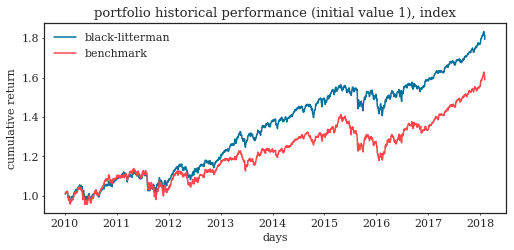

In [157]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white', {"xtick.major.size": 2, "ytick.major.size": 2})
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71","#f4cae4"]
sns.set_palette(sns.color_palette(flatui,7))

font = {'family' : 'Serif',
         'weight': 'normal',
         'size'  : 11}
mpl.rc('font', **font)
# a4 size: 8.27,11.69
fig = plt.figure(figsize=(8.27,3.5))
ax = fig.add_subplot(111)

ax.plot(index_date, cum_p, c = 'xkcd:ocean blue', label ='black-litterman')
ax.plot(index_date, cum_p_benchmark, c = 'xkcd:light red', label = 'benchmark')
# print((cum_p_benchmark-cum_p).shape)
diff_second=np.argsort(cum_p_benchmark-cum_p)[:3]
diff_first=np.argsort((cum_p_benchmark-cum_p)[:1000])[:3]
diff=np.append(diff_first,diff_second)
print(diff)
# ax.vlines(index_date[append(diff_first,diff_second)],0.95,1.6,linestyles='dotted')

ax.set_xlabel('days')
ax.set_ylabel('cumulative return')
ax.set_title('portfolio historical performance (initial value 1), index')

plt.legend(loc='best')
plt.show()


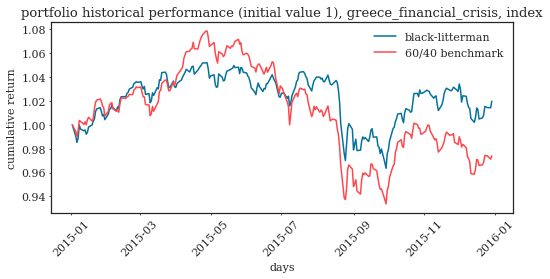

In [155]:
# greece financial crisis 2015。 Starts from 1.25 the president won the election. Blocking Austerity
# greece financial crisis 2.0
mask_greece=(index_date>'2015-01-01')&(index_date<'2015-12-30')
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white', {"xtick.major.size": 2, "ytick.major.size": 2})
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71","#f4cae4"]
sns.set_palette(sns.color_palette(flatui,7))

font = {'family' : 'Serif',
         'weight': 'normal',
         'size'  : 11}
mpl.rc('font', **font)
# a4 size: 8.27,11.69
fig = plt.figure(figsize=(8.27,3.5))
ax = fig.add_subplot(111)

ax.plot(index_date[mask_greece], cum_p[mask_greece]/cum_p[mask_greece][0], c = 'xkcd:ocean blue', label ='black-litterman')
ax.plot(index_date[mask_greece], cum_p_benchmark[mask_greece]/cum_p_benchmark[mask_greece][0], c = 'xkcd:light red', label = '60/40 benchmark')

ax.set_xlabel('days')
ax.set_ylabel('cumulative return')
plt.xticks(rotation=45)
ax.set_title('portfolio historical performance (initial value 1), greece_financial_crisis, index')

plt.legend(loc='best') 
plt.show()

In [136]:
# europe soverign debt crisis
mask_europe_debt=(index_date>'2010-03-01')&(index_date<'2010-06-01')
index=index_date[mask_europe_debt]
port=cum_p[mask_europe_debt]/cum_p[mask_europe_debt][0]
bench=cum_p_benchmark[mask_europe_debt]/cum_p_benchmark[mask_europe_debt][0]
europe_debt=pd.DataFrame(index=index,data=np.vstack((bench,port)).transpose(),columns=['benchmark','black_litterman'])

mask_flash_crash=(index_date>'2010-04-01')&(index_date<'2010-05-30')
index=index_date[mask_flash_crash]
port=cum_p[mask_flash_crash]/cum_p[mask_flash_crash][0]
bench=cum_p_benchmark[mask_flash_crash]/cum_p_benchmark[mask_flash_crash][0]
flash_crash=pd.DataFrame(index=index,data=np.vstack((bench,port)).transpose(),columns=['benchmark','black_litterman'])

mask_fall=(index_date>'2011-07-01')&(index_date<'2011-08-30')
index=index_date[mask_fall]
port=cum_p[mask_fall]/cum_p[mask_fall][0]
bench=cum_p_benchmark[mask_fall]/cum_p_benchmark[mask_fall][0]
mark_fall=pd.DataFrame(index=index,data=np.vstack((bench,port)).transpose(),columns=['benchmark','black_litterman'])


mask_2015_crash=(index_date>'2015-06-01')&(index_date<'2015-09-01')
index=index_date[mask_2015_crash]
port=cum_p[mask_2015_crash]/cum_p[mask_2015_crash][0]
bench=cum_p_benchmark[mask_2015_crash]/cum_p_benchmark[mask_2015_crash][0]
crash_2015=pd.DataFrame(index=index,data=np.vstack((bench,port)).transpose(),columns=['benchmark','black_litterman'])

mask_2015_drop=(index_date>'2015-07-10')&(index_date<'2015-08-30')
index=index_date[mask_2015_drop]
port=cum_p[mask_2015_drop]/cum_p[mask_2015_drop][0]
bench=cum_p_benchmark[mask_2015_drop]/cum_p_benchmark[mask_2015_drop][0]
drop_2015=pd.DataFrame(index=index,data=np.vstack((bench,port)).transpose(),columns=['benchmark','black_litterman'])


mask_greece=(index_date>'2015-01-01')&(index_date<'2015-12-30')
index=index_date[mask_greece]
port=cum_p[mask_greece]/cum_p[mask_greece][0]
bench=cum_p_benchmark[mask_greece]/cum_p_benchmark[mask_greece][0]
greece=pd.DataFrame(index=index,data=np.vstack((bench,port)).transpose(),columns=['benchmark','black_litterman'])


writer=pd.ExcelWriter('xlsx/scenarios_updated.xlsx')
europe_debt.to_excel(writer, 'europe_severign_debt')
mark_fall.to_excel(writer,'2011 stock markets fall')
flash_crash.to_excel(writer,'2010 flash crash')
crash_2015.to_excel(writer,'2015_crash')
drop_2015.to_excel(writer,'drop 2015')
greece.to_excel(writer,'greece financial crisis2.0')
writer.save()

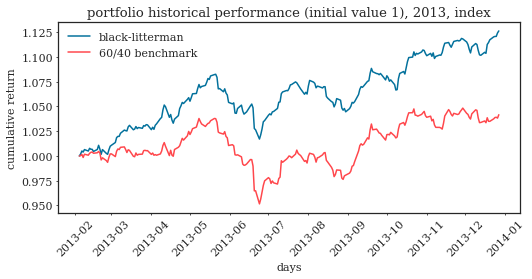

In [137]:
mask_2011=(index_date>'2013-10-01')&(index_date<'2014-10-01')
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white', {"xtick.major.size": 2, "ytick.major.size": 2})
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71","#f4cae4"]
sns.set_palette(sns.color_palette(flatui,7))

font = {'family' : 'Serif',
         'weight': 'normal',
         'size'  : 11}
mpl.rc('font', **font)
# a4 size: 8.27,11.69
fig = plt.figure(figsize=(8.27,3.5))
ax = fig.add_subplot(111)

ax.plot(index_date[mask_2013], cum_p[mask_2013]/cum_p[mask_2013][0], c = 'xkcd:ocean blue', label ='black-litterman')
ax.plot(index_date[mask_2013], cum_p_benchmark[mask_2013]/cum_p_benchmark[mask_2013][0], c = 'xkcd:light red', label = '60/40 benchmark')

ax.set_xlabel('days')
ax.set_ylabel('cumulative return')
plt.xticks(rotation=45)
ax.set_title('portfolio historical performance (initial value 1), 2013, index')

plt.legend(loc='best') 
plt.show()

In [138]:
cum_p_e = compute_historical_performance(daily_return[0:5,:], new_weights[0:5]/np.sum(new_weights[0:5]))
cum_p_benchmark_e = compute_historical_performance(daily_return[0:5,:], benchmark_weight[0:5]/np.sum(benchmark_weight[0:5]))
cum_p_b = compute_historical_performance(daily_return[6:,:], new_weights[6:]/np.sum(new_weights[6:]))
cum_p_benchmark_b = compute_historical_performance(daily_return[6:,:], benchmark_weight[6:]/np.sum(benchmark_weight[6:]))

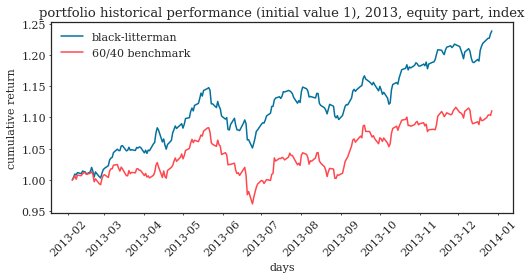

In [139]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white', {"xtick.major.size": 2, "ytick.major.size": 2})
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71","#f4cae4"]
sns.set_palette(sns.color_palette(flatui,7))

font = {'family' : 'Serif',
         'weight': 'normal',
         'size'  : 11}
mpl.rc('font', **font)
# a4 size: 8.27,11.69
fig = plt.figure(figsize=(8.27,3.5))
ax = fig.add_subplot(111)

ax.plot(index_date[mask_2013], cum_p_e[mask_2013]/cum_p_e[mask_2013][0], c = 'xkcd:ocean blue', label ='black-litterman')
ax.plot(index_date[mask_2013], cum_p_benchmark_e[mask_2013]/cum_p_benchmark_e[mask_2013][0], c = 'xkcd:light red', label = '60/40 benchmark')

plt.xticks(rotation=45)
ax.set_xlabel('days')
ax.set_ylabel('cumulative return')
ax.set_title('portfolio historical performance (initial value 1), 2013, equity part, index')

plt.legend(loc='best') 
plt.show()

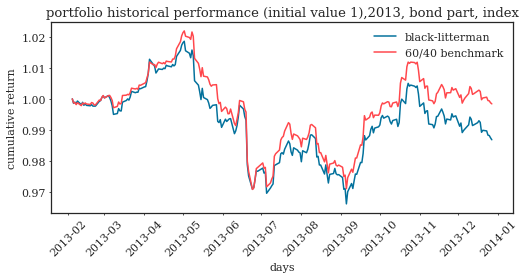

In [163]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white', {"xtick.major.size": 2, "ytick.major.size": 2})
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71","#f4cae4"]
sns.set_palette(sns.color_palette(flatui,7))

font = {'family' : 'Serif',
         'weight': 'normal',
         'size'  : 11}
mpl.rc('font', **font)
# a4 size: 8.27,11.69
fig = plt.figure(figsize=(8.27,3.5))
ax = fig.add_subplot(111)

ax.plot(index_date[mask_2013], cum_p_b[mask_2013]/cum_p_b[mask_2013][0], c = 'xkcd:ocean blue', label ='black-litterman')
ax.plot(index_date[mask_2013], cum_p_benchmark_b[mask_2013]/cum_p_benchmark_b[mask_2013][0], c = 'xkcd:light red', label = '60/40 benchmark')

ax.set_xlabel('days')
ax.set_ylabel('cumulative return')
plt.xticks(rotation=45)
ax.set_title('portfolio historical performance (initial value 1),2013, bond part, index')

plt.legend(loc='best') 
plt.show()  

In [164]:
mask_2011=(index_date>'2011-07-01')&(index_date<'2011-10-030')

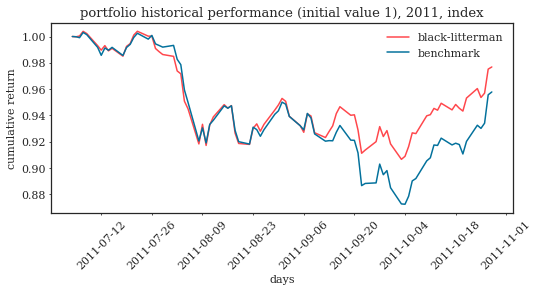

In [165]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white', {"xtick.major.size": 2, "ytick.major.size": 2})
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71","#f4cae4"]
sns.set_palette(sns.color_palette(flatui,7))

font = {'family' : 'Serif',
         'weight': 'normal',
         'size'  : 11}
mpl.rc('font', **font)
# a4 size: 8.27,11.69
fig = plt.figure(figsize=(8.27,3.5))
ax = fig.add_subplot(111)

ax.plot(index_date[mask_2011], cum_p[mask_2011]/cum_p[mask_2011][0], c = 'xkcd:light red', label ='black-litterman')
ax.plot(index_date[mask_2011], cum_p_benchmark[mask_2011]/cum_p_benchmark[mask_2011][0], c = 'xkcd:ocean blue', label = 'benchmark')

plt.xticks(rotation=45)
ax.set_xlabel('days')
ax.set_ylabel('cumulative return')
ax.set_title('portfolio historical performance (initial value 1), 2011, index')

# max_diff=cum_p[mask_2011]-cum_p_benchmark[mask_2011]
# print(np.argmax())

plt.legend(loc='best') 
plt.show()     

In [143]:
mask_2015=(index_date>'2015-07-01')&(index_date<'2016-07-01')

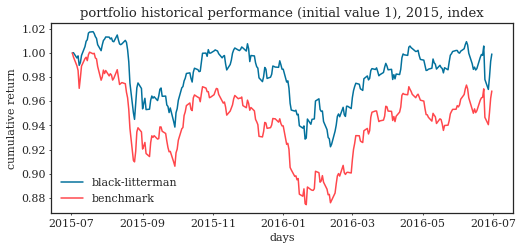

In [160]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white', {"xtick.major.size": 2, "ytick.major.size": 2})
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71","#f4cae4"]
sns.set_palette(sns.color_palette(flatui,7))

font = {'family' : 'Serif',
         'weight': 'normal',
         'size'  : 11}
mpl.rc('font', **font)
# a4 size: 8.27,11.69
fig = plt.figure(figsize=(8.27,3.5))
ax = fig.add_subplot(111)

ax.plot(index_date[mask_2015], cum_p[mask_2015]/cum_p[mask_2015][0], c = 'xkcd:ocean blue', label ='black-litterman')
ax.plot(index_date[mask_2015], cum_p_benchmark[mask_2015]/cum_p_benchmark[mask_2015][0], c = 'xkcd:light red', label = 'benchmark')

ax.set_xlabel('days')
ax.set_ylabel('cumulative return')
ax.set_title('portfolio historical performance (initial value 1), 2015, index')

plt.legend(loc='best') 
plt.show()     

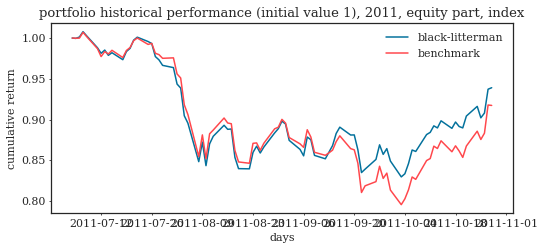

In [159]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white', {"xtick.major.size": 2, "ytick.major.size": 2})
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71","#f4cae4"]
sns.set_palette(sns.color_palette(flatui,7))

font = {'family' : 'Serif',
         'weight': 'normal',
         'size'  : 11}
mpl.rc('font', **font)
# a4 size: 8.27,11.69
fig = plt.figure(figsize=(8.27,3.5))
ax = fig.add_subplot(111)

ax.plot(index_date[mask_2011], cum_p_e[mask_2011]/cum_p_e[mask_2011][0], c = 'xkcd:ocean blue', label ='black-litterman')
ax.plot(index_date[mask_2011], cum_p_benchmark_e[mask_2011]/cum_p_benchmark_e[mask_2011][0], c = 'xkcd:light red', label = 'benchmark')

ax.set_xlabel('days')
ax.set_ylabel('cumulative return')
ax.set_title('portfolio historical performance (initial value 1), 2011, equity part, index')

plt.legend(loc='best') 
plt.show()     

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white', {"xtick.major.size": 2, "ytick.major.size": 2})
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71","#f4cae4"]
sns.set_palette(sns.color_palette(flatui,7))

font = {'family' : 'Serif',
         'weight': 'normal',
         'size'  : 11}
mpl.rc('font', **font)
# a4 size: 8.27,11.69
fig = plt.figure(figsize=(8.27,3.5))
ax = fig.add_subplot(111)

ax.plot(index_date[mask_2011], cum_p_b[mask_2011]/cum_p_b[mask_2011][0], c = 'xkcd:ocean blue', label ='black-litterman')
ax.plot(index_date[mask_2011], cum_p_benchmark_b[mask_2011]/cum_p_benchmark_b[mask_2011][0], c = 'xkcd:light red', label = 'benchmark')

ax.set_xlabel('days')
ax.set_ylabel('cumulative return')
ax.set_title('portfolio historical performance (initial value 1),2011, bond part, index')

plt.legend(loc='best') 
plt.show()     

In [ ]:
# plot the pure bond, index and benchmark together

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white', {"xtick.major.size": 2, "ytick.major.size": 2})
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71","#f4cae4"]
sns.set_palette(sns.color_palette(flatui,7))

font = {'family' : 'Serif',
         'weight': 'normal',
         'size'  : 11}
mpl.rc('font', **font)
# a4 size: 8.27,11.69
fig = plt.figure(figsize=(8.27,3.5))
ax = fig.add_subplot(111)

ax.plot(index_date[mask_2011], cum_p_b[mask_2011]/cum_p_b[mask_2011][0], c = 'xkcd:ocean blue', label ='black-litterman bond')
ax.plot(index_date[mask_2011], cum_p_benchmark_b[mask_2011]/cum_p_benchmark_b[mask_2011][0], c = 'xkcd:light red', label = 'benchmark bond')
ax.plot(index_date[mask_2011], cum_p[mask_2011]/cum_p[mask_2011][0], c = "#a00498", label ='black-litterman')
ax.plot(index_date[mask_2011], cum_p_benchmark[mask_2011]/cum_p_benchmark[mask_2011][0], c = "#fe828c", label ='benchmark')

plt.xticks(rotation=45)
ax.set_xlabel('days')
ax.set_ylabel('cumulative return')
ax.set_title('portfolio historical performance (initial value 1),2011, bond part, index')

plt.legend(loc='best') 
plt.show()

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white', {"xtick.major.size": 2, "ytick.major.size": 2})
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71","#f4cae4"]
sns.set_palette(sns.color_palette(flatui,7))

font = {'family' : 'Serif',
         'weight': 'normal',
         'size'  : 11}
mpl.rc('font', **font)
# a4 size: 8.27,11.69
fig = plt.figure(figsize=(8.27,3.5))
ax = fig.add_subplot(111)

ax.plot(index_date[mask_2015], cum_p_e[mask_2015]/cum_p_e[mask_2015][0], c = 'xkcd:ocean blue', label ='black-litterman')
ax.plot(index_date[mask_2015], cum_p_benchmark_e[mask_2015]/cum_p_benchmark_e[mask_2015][0], c = 'xkcd:light red', label = 'benchmark')

ax.set_xlabel('days')
ax.set_ylabel('cumulative return')
ax.set_title('portfolio historical performance (initial value 1), 2015, equity part, index')

plt.legend(loc='best') 
plt.show()     

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white', {"xtick.major.size": 2, "ytick.major.size": 2})
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71","#f4cae4"]
sns.set_palette(sns.color_palette(flatui,7))

font = {'family' : 'Serif',
         'weight': 'normal',
         'size'  : 11}
mpl.rc('font', **font)
# a4 size: 8.27,11.69
fig = plt.figure(figsize=(8.27,3.5))
ax = fig.add_subplot(111)

ax.plot(index_date[mask_2015], cum_p_b[mask_2015]/cum_p_b[mask_2015][0], c = 'xkcd:ocean blue', label ='black-litterman')
ax.plot(index_date[mask_2015], cum_p_benchmark_b[mask_2015]/cum_p_benchmark_b[mask_2015][0], c = 'xkcd:light red', label = 'benchmark')

ax.set_xlabel('days')
ax.set_ylabel('cumulative return')
ax.set_title('portfolio historical performance (initial value 1),2015, bond part, index')

plt.legend(loc='best') 
plt.show()    

In [ ]:
cum_p = compute_historical_performance(etf_return.values.transpose(), new_weights)
cum_p_benchmark = compute_historical_performance(etf_return.values.transpose(), benchmark_weight)
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white', {"xtick.major.size": 2, "ytick.major.size": 2})
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71","#f4cae4"]
sns.set_palette(sns.color_palette(flatui,7))

font = {'family' : 'Serif',
         'weight': 'normal',
         'size'  : 11}
mpl.rc('font', **font)
# a4 size: 8.27,11.69
fig = plt.figure(figsize=(8.27,3.5))
ax = fig.add_subplot(111)

ax.plot(etf_date, cum_p, c = 'xkcd:ocean blue', label ='black-litterman')
ax.plot(etf_date, cum_p_benchmark, c = 'xkcd:light red', label = 'benchmark')
ax.set_xlabel('days')
ax.set_ylabel('cumulative return')
ax.set_title('portfolio historical performance (initial value 1), etf')

plt.legend(loc='best') 
plt.show()     

In [ ]:
mask_crash = (etf_date>'2017-12-31')

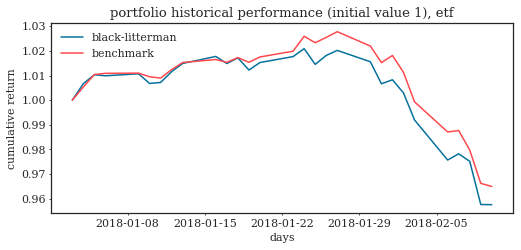

In [147]:
cum_p = compute_historical_performance(etf_return.values.transpose(), new_weights)
cum_p_benchmark = compute_historical_performance(etf_return.values.transpose(), benchmark_weight)
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white', {"xtick.major.size": 2, "ytick.major.size": 2})
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71","#f4cae4"]
sns.set_palette(sns.color_palette(flatui,7))

font = {'family' : 'Serif',
         'weight': 'normal',
         'size'  : 11}
mpl.rc('font', **font)
# a4 size: 8.27,11.69
fig = plt.figure(figsize=(8.27,3.5))
ax = fig.add_subplot(111)

ax.plot(etf_date[mask_crash], cum_p[mask_crash]/cum_p[mask_crash][0], c = 'xkcd:ocean blue', label ='black-litterman')
ax.plot(etf_date[mask_crash], cum_p_benchmark[mask_crash]/cum_p_benchmark[mask_crash][0], c = 'xkcd:light red', label = 'benchmark')
ax.set_xlabel('days')
ax.set_ylabel('cumulative return')
ax.set_title('portfolio historical performance (initial value 1), etf')

plt.legend(loc='best') 
plt.show()   

In [161]:
index=etf_date[mask_crash]
port=cum_p[mask_crash]/cum_p[mask_crash][0]
bench= cum_p_benchmark[mask_crash]/cum_p_benchmark[mask_crash][0]
near_crash=pd.DataFrame(index=index,data=np.vstack((bench,port)).transpose(),columns=['benchmark','black_litterman'])
writer=pd.ExcelWriter('xlsx/scenarios_updated(2).xlsx')
near_crash.to_excel(writer,'2018 crash')
writer.save()

IndexError: boolean index did not match indexed array along dimension 0; dimension is 2110 but corresponding boolean dimension is 965

In [162]:
# plot the posterior m-v frontier
n = 80
plot_mean = np.zeros(n)
plot_var = np.zeros(n)
for i in range(n):
    r_target = 0.02+i*0.001
    new_weights = solve_weights(Pi_new+rf, C, rf, r_target = r_target, daily_return = daily_return, asset_beta = asset_beta)
    plot_mean[i], plot_var[i] = compute_mean_var(new_weights, Pi_new + rf, C) 

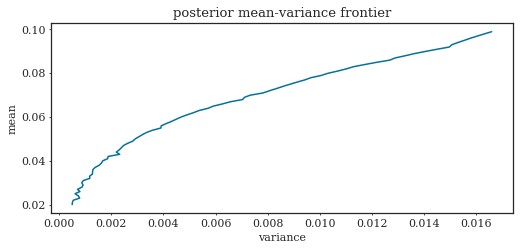

In [35]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white', {"xtick.major.size": 2, "ytick.major.size": 2})
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71","#f4cae4"]
sns.set_palette(sns.color_palette(flatui,7))

font = {'family' : 'Serif',
         'weight': 'normal',
         'size'  : 11}
mpl.rc('font', **font)
# a4 size: 8.27,11.69
fig = plt.figure(figsize=(8.27,3.5))
ax = fig.add_subplot(111)

ax.plot(plot_var, plot_mean, c = 'xkcd:ocean blue')
ax.set_xlabel('variance')
ax.set_ylabel('mean')
ax.set_title('posterior mean-variance frontier')

plt.legend(loc='best') 
plt.show()            